# Illustrate the Effect of Varying SA Locations 

In [37]:
from src.data.preprocess_utils import filter, bin_data, smooth_signal, butter_lowpass, remove_drift
from sklearn.decomposition import FastICA
from statsmodels.tsa.stattools import acf
from matplotlib import pyplot as plt 
from scipy.signal import find_peaks 
from tqdm import tqdm 
import seaborn as sns 
import numpy as np 
import pickle 
import os 

sns.set_theme()

rcParams = {
    "font.family": "serif",  # use serif/main font for text elements
    'text.usetex': True,
    'font.size': 8,
    'axes.labelsize': 7,
    'axes.titlesize': 9,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 7,
    'axes.labelpad': 1,
    'axes.axisbelow': True,  # draw gridlines below other elements
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
    "pgf.preamble": "\n".join([
        r"\usepackage{url}",            # load additional packages
        r"\usepackage{amsmath,amssymb}",   # unicode math setup
        #  r"\setmainfont{DejaVu Serif}",  # serif font via preamble
    ])
}
plt.rcParams.update(rcParams)

figdir = "../../../figures/methods/"
def savefig(fig, name, width=6, height=4):
    # apply rcParams
    fig.set_size_inches(width, height)
    fig.savefig(figdir + name + ".pdf", bbox_inches='tight')

### Read data 

In [42]:
with open("simulated_data_new.pkl", "rb") as file: 
    data_no_offset = pickle.load(file)
file.close()
with open("simulated_data.pkl", "rb") as file: 
    data_offset = pickle.load(file)
file.close()

pli_signal = np.load("../data/noise_files_sim_data/pli.npy")

obs_no_offset = data_no_offset['obs_signal']
obs_offset = data_offset['obs_signal']

### Find ICA component with highest ACF at 50 Hz 

In [26]:
ica_no_offset = FastICA(n_components=32)
ica_offset = FastICA(n_components=32)

ica_comp_no_offset = ica_no_offset.fit_transform(smooth_signal(butter_lowpass(remove_drift(obs_no_offset)), window_len=5))
ica_comp_offset = ica_offset.fit_transform(smooth_signal(butter_lowpass(remove_drift(obs_offset)), window_len=5))

acfs_no_offset = np.zeros(32)
acfs_offset = np.zeros(32)

for channel in tqdm(range(32)):
    # find for no offset 
    peaks, _ = find_peaks(obs_no_offset[:, channel], height = 500, distance = 2900)
    bins = bin_data(ica_comp_no_offset[:, channel], peaks).ravel()
    acf_tmp = acf(bins, nlags = 600)
    acfs_no_offset[channel] = acf_tmp[-1]


    # find for offset 
    peaks, _ = find_peaks(obs_offset[:, channel], height = 500, distance = 2900)
    bins = bin_data(ica_comp_offset[:, channel], peaks).ravel()
    acf_tmp = acf(bins, nlags = 600)
    acfs_offset[channel] = acf_tmp[-1]



100%|██████████| 32/32 [00:03<00:00,  9.91it/s]


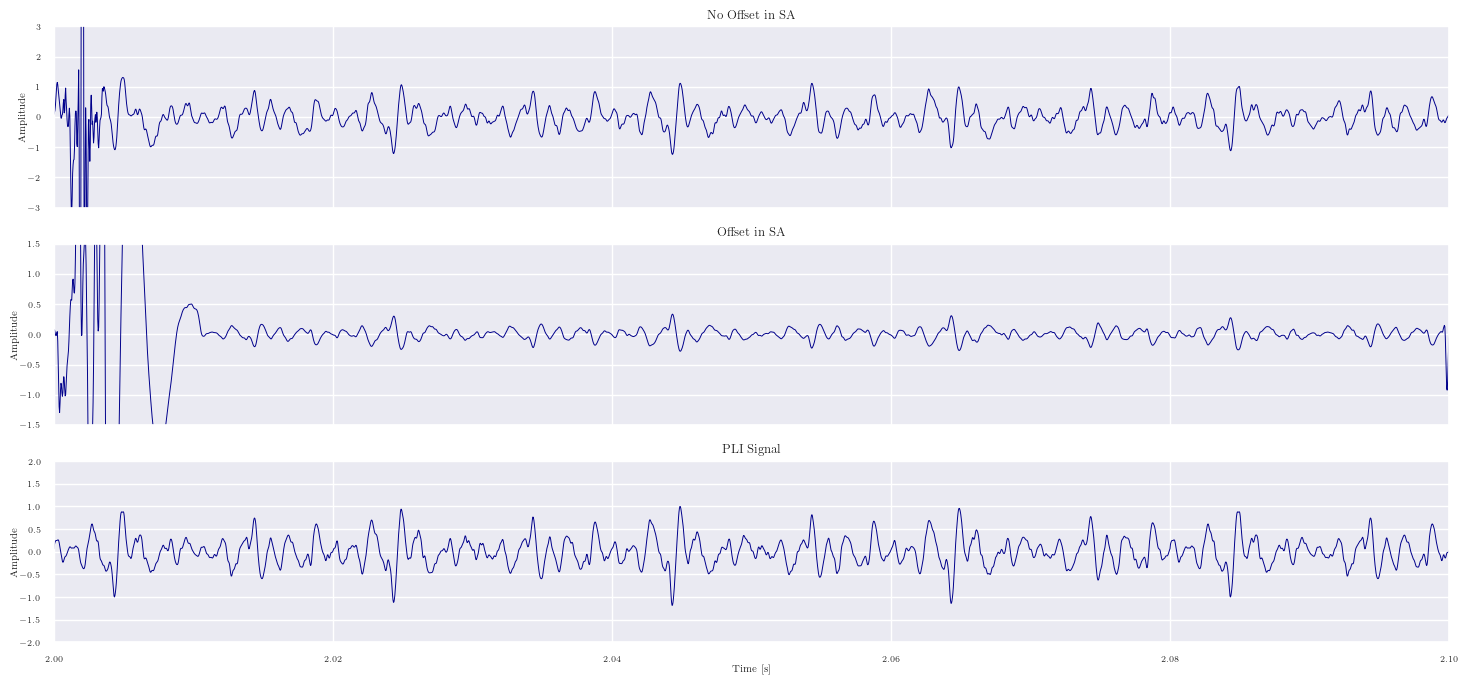

In [76]:
comp_no_offset = ica_comp_no_offset[:, np.argmax(acfs_no_offset)]
comp_offset = ica_comp_offset[:, np.argmax(acfs_offset)]

x_axis = np.arange(len(comp_no_offset)) / 30000 

fig, ax = plt.subplots(3, 1, figsize = (18, 8), sharex = True)
ax[0].plot(x_axis, comp_no_offset, color = "darkblue", linewidth = 0.7)
ax[0].set_ylim([-3, 3])
ax[0].set_title("No Offset in SA")


ax[1].plot(x_axis, comp_offset, color = "darkblue", linewidth = 0.7)
ax[1].set_ylim([-1.5, 1.5])
ax[1].set_title("Offset in SA")

ax[2].plot(x_axis, pli_signal, color = "darkblue", linewidth = 0.7)
ax[2].set_ylim([-2, 2])
ax[2].set_title("PLI Signal")
ax[2].set_xlabel("Time [s]")

[a.set_xlim([2, 2.1]) for a in ax]
[a.set_ylabel("Amplitude") for a in ax]

plt.show()

savefig(fig, "offset_ICA_compontents", width = 6.5, height=1.5*2.5)

### Compare Preprocessing 

In [50]:
filtered_no_offset, _ = filter(obs_no_offset)
filtered_offset, _ = filter(obs_offset)

Original ACF : 0.942498931860263
new acf :  0.05613201253367664
ratio : 0.05955657946782575
Original ACF : 0.5767470678894021
new acf :  0.5269069855585302
ratio : 0.9135841600144393
new acf :  0.49441154287744726
ratio : 0.8572415368954357
new acf :  0.4715371553695249
ratio : 0.8175804986666141
new acf :  0.4742727936445982
ratio : 0.8223237187493521
new acf :  0.47254097717266114
ratio : 0.819320987451082
new acf :  0.4756456464311183
ratio : 0.8247040564449455
new acf :  0.4494572604926974
ratio : 0.7792970012617143
new acf :  0.4425405917783959
ratio : 0.7673044501082026
new acf :  0.4313761207349011
ratio : 0.747946794620935
new acf :  0.3949775526541565
ratio : 0.6848366895033752


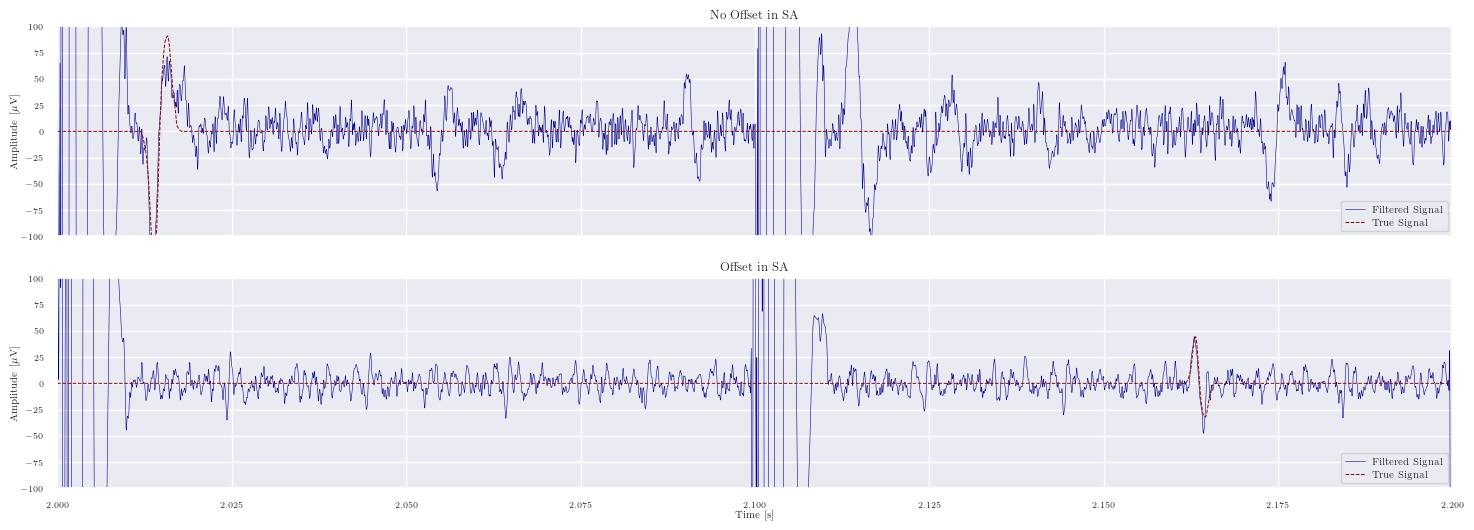

In [79]:
channel = 15 

fig, ax = plt.subplots(2, 1, figsize = (18, 6), sharex = True, sharey = True)
ax[0].plot(x_axis, filtered_no_offset[:, channel], color = "darkblue", linewidth = 0.4, label = "Filtered Signal")
ax[0].plot(x_axis, data_no_offset['true_signal'][:, channel], "--",  color = "darkred", linewidth = 0.7, label = "True Signal")
ax[0].set_title("No Offset in SA")

ax[1].plot(x_axis, filtered_offset[:, channel], color = "darkblue", linewidth = 0.4, label = "Filtered Signal")
ax[1].plot(x_axis, data_offset['true_signal'][:, channel], "--",  color = "darkred", linewidth = 0.7, label = "True Signal")
ax[1].set_xlabel("Time [s]")
ax[1].set_title("Offset in SA")

[a.set_xlim([2, 2.2]) for a in ax]
[a.set_ylim([-100, 100]) for a in ax]
[a.set_ylabel(r"Amplitude [$\mu$V]") for a in ax]
[a.legend(loc = "lower right") for a in ax]

plt.show()

savefig(fig, "offset_preprocessing", width = 6.5, height=1.5*2)